## Basics

### Imports

In [74]:
import pandas as pd
import numpy as np
import os

import torch
from matplotlib import pyplot as plt
import seaborn as sns
from torchgen.packaged.autograd.load_derivatives import load_derivatives
from zmq.auth import load_certificate

In [61]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, max_error

from sklearn.linear_model import LinearRegression

### Working Directory Path

In [2]:
# Local Path for Running Locally
path = "./data/"
path_images = path + "images/"
path_features = path + "features/"

### Read Data & Features

In [32]:
data = pd.read_csv(path + 'agora12_data_pp.csv')
data

,Id,FullText,ImageFilename,StartYear,EndYear,MidpointYear,YearRange,HistoricalPeriod,ValidChronology
0,Agora:Object:Agora XII:1,foot missing. offset neck and echinoid mouth; ...,Agora_Image_2012.54.1450.jpg,-575.0,-550.0,-562.5,25.0,Archaic,True
1,Agora:Object:Agora XII:2,spreading ring foot with torus outer and conve...,NaN,-525.0,-500.0,-512.5,25.0,Archaic,True
2,Agora:Object:Agora XII:3,flaring ring foot. torus mouth. ridge at junct...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
3,Agora:Object:Agora XII:4,ring foot. echinoid mouth inset from neck and ...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
4,Agora:Object:Agora XII:5,echinus ring foot. torus mouth; strap handles....,Agora_Image_2012.27.0009.jpg,-525.0,-500.0,-512.5,25.0,Archaic,True
...,...,...,...,...,...,...,...,...,...
1995,Agora:Object:Agora XII:2036,fragment of rim and floor with handle. deep ba...,NaN,-350.0,-320.0,-335.0,30.0,Classical,True
1996,Agora:Object:Agora XII:2037,handles missing. basin and lid; handles probab...,Agora_Image_2012.55.1261.jpg,-350.0,-301.0,-325.5,49.0,Classical,True
1997,Agora:Object:Agora XII:2038,small series. plain flat-topped rim; flaring b...,Agora_Image_2012.25.0184.jpg,-435.0,-425.0,-430.0,10.0,Classical,True
1998,Agora:Object:Agora XII:2039,"small series. rim flat on top, roughly moulded...",Agora_Image_2012.55.1268.jpg,-375.0,-325.0,-350.0,50.0,Classical,True


In [4]:
f_types = {
    "vectors": ("csv", pd.read_csv, {}),
    "tensors": ("pt", torch.load, {"weights_only": True})
}
d_types_methods = {
    "text": ("tfidf", "bert"),
    "image": ("cannyhog", "resnet", "vit")
}

In [19]:
features = {ft:{} for ft in f_types}
for feature_type, (ext, loader, params) in f_types.items():
    for data_type, methods in d_types_methods.items():
        for method in methods:
            filename = f"{data_type}_{method}_{feature_type}.{ext}"
            file_path = os.path.join(path_features, filename)
            if os.path.exists(file_path):
                features[feature_type][method] = loader(file_path, **params)
                print(f"Loaded {filename}")

Loaded text_tfidf_vectors.csv
Loaded text_bert_vectors.csv
Loaded image_cannyhog_vectors.csv
Loaded image_resnet_vectors.csv
Loaded image_vit_vectors.csv
Loaded text_bert_tensors.pt
Loaded image_resnet_tensors.pt
Loaded image_vit_tensors.pt


In [27]:
for method in features["vectors"]:
    print(f"\nfeatures[\"vectors\"][\"{method}\"] = ")
    print(features["vectors"][method].info())


features["vectors"]["tfidf"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 300 entries, F0 to F299
dtypes: float64(300)
memory usage: 4.6 MB
None

features["vectors"]["bert"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.7 MB
None

features["vectors"]["cannyhog"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2917 entries, F0 to F2916
dtypes: float64(2917)
memory usage: 44.5 MB
None

features["vectors"]["resnet"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 2048 entries, F0 to F2047
dtypes: float64(2048)
memory usage: 31.3 MB
None

features["vectors"]["vit"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.7 MB
None


In [28]:
for method in features["tensors"]:
    if method in features["tensors"]:
        print(f"\nfeatures[\"tensors\"][\"{method}\"] = ")
        tensor = features["tensors"][method]
        print(f"Dimensions: {tensor.ndim}\nShape: {tensor.shape}\ndtype: {tensor.dtype}\nMemory usage: {(tensor.element_size() * tensor.numel()) / (1024 * 1024)} MB")


features["tensors"]["bert"] = 
Dimensions: 2
Shape: torch.Size([2000, 768])
dtype: torch.float32
Memory usage: 5.859375 MB

features["tensors"]["resnet"] = 
Dimensions: 2
Shape: torch.Size([2000, 2048])
dtype: torch.float32
Memory usage: 15.625 MB

features["tensors"]["vit"] = 
Dimensions: 2
Shape: torch.Size([2000, 768])
dtype: torch.float32
Memory usage: 5.859375 MB


### Evaluation Metrics Table

In [56]:
metrics = [
    "mae",
    "rmse",
    "r2",
    "medae",
    "maxerror"
]

In [58]:
scores = pd.DataFrame(columns=[
    "model",
    "features",
    "target",
] + metrics)

### Drop Records with Non-Valid Chronology (Null or Range > 50)

In [29]:
valid_mask = data["ValidChronology"]

In [33]:
data = data.loc[valid_mask].reset_index(drop=True)
data

,Id,FullText,ImageFilename,StartYear,EndYear,MidpointYear,YearRange,HistoricalPeriod,ValidChronology
0,Agora:Object:Agora XII:1,foot missing. offset neck and echinoid mouth; ...,Agora_Image_2012.54.1450.jpg,-575.0,-550.0,-562.5,25.0,Archaic,True
1,Agora:Object:Agora XII:2,spreading ring foot with torus outer and conve...,NaN,-525.0,-500.0,-512.5,25.0,Archaic,True
2,Agora:Object:Agora XII:3,flaring ring foot. torus mouth. ridge at junct...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
3,Agora:Object:Agora XII:4,ring foot. echinoid mouth inset from neck and ...,NaN,-500.0,-500.0,-500.0,0.0,Archaic,True
4,Agora:Object:Agora XII:5,echinus ring foot. torus mouth; strap handles....,Agora_Image_2012.27.0009.jpg,-525.0,-500.0,-512.5,25.0,Archaic,True
...,...,...,...,...,...,...,...,...,...
1905,Agora:Object:Agora XII:2035,fragments from two closely similar examples; c...,Agora_Image_2012.56.0490.jpg,-375.0,-325.0,-350.0,50.0,Classical,True
1906,Agora:Object:Agora XII:2036,fragment of rim and floor with handle. deep ba...,NaN,-350.0,-320.0,-335.0,30.0,Classical,True
1907,Agora:Object:Agora XII:2037,handles missing. basin and lid; handles probab...,Agora_Image_2012.55.1261.jpg,-350.0,-301.0,-325.5,49.0,Classical,True
1908,Agora:Object:Agora XII:2038,small series. plain flat-topped rim; flaring b...,Agora_Image_2012.25.0184.jpg,-435.0,-425.0,-430.0,10.0,Classical,True


In [34]:
for method in features["vectors"]:
    features["vectors"][method] = features["vectors"][method].loc[valid_mask].reset_index(drop=True)

    print(f"\nfeatures[\"vectors\"][\"{method}\"] = ")
    print(features["vectors"][method].info())


features["vectors"]["tfidf"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 300 entries, F0 to F299
dtypes: float64(300)
memory usage: 4.4 MB
None

features["vectors"]["bert"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.2 MB
None

features["vectors"]["cannyhog"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 2917 entries, F0 to F2916
dtypes: float64(2917)
memory usage: 42.5 MB
None

features["vectors"]["resnet"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 2048 entries, F0 to F2047
dtypes: float64(2048)
memory usage: 29.8 MB
None

features["vectors"]["vit"] = 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1910 entries, 0 to 1909
Columns: 768 entries, F0 to F767
dtypes: float64(768)
memory usage: 11.2 MB
None


In [36]:
for method, tensor in features["tensors"].items():
    features["tensors"][method] = tensor[valid_mask.values]  # convert mask to numpy

    print(f"\nfeatures[\"tensors\"][\"{method}\"] = ")
    tensor = features["tensors"][method]
    print(f"Dimensions: {tensor.ndim}\nShape: {tensor.shape}\ndtype: {tensor.dtype}\nMemory usage: {(tensor.element_size() * tensor.numel()) / (1024 * 1024)} MB")


features["tensors"]["bert"] = 
Dimensions: 2
Shape: torch.Size([1910, 768])
dtype: torch.float32
Memory usage: 5.595703125 MB

features["tensors"]["resnet"] = 
Dimensions: 2
Shape: torch.Size([1910, 2048])
dtype: torch.float32
Memory usage: 14.921875 MB

features["tensors"]["vit"] = 
Dimensions: 2
Shape: torch.Size([1910, 768])
dtype: torch.float32
Memory usage: 5.595703125 MB


## Target

In [ ]:
target = {
    "start_year": data["start_year"],
}

## Split Train & Test Sets

In [44]:
indices = np.arange(data.shape[0])
train_idx, test_idx = train_test_split(indices, test_size=0.1, random_state=42)

In [47]:
X = {}
for method, vectors in features["vectors"].items():
    X[method] = {
        "train": vectors.loc[train_idx],
        "test": vectors.loc[test_idx]
    }

In [48]:
X

{'tfidf': {'train':        F0        F1        F2   F3        F4        F5   F6   F7   F8  \
  1455  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  482   0.0  0.139391  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  772   0.0  0.000000  0.000000  0.0  0.000000  0.133552  0.0  0.0  0.0   
  1192  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1007  0.0  0.000000  0.202137  0.0  0.000000  0.000000  0.0  0.0  0.0   
  ...   ...       ...       ...  ...       ...       ...  ...  ...  ...   
  1130  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1294  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  860   0.0  0.160136  0.000000  0.0  0.170923  0.143958  0.0  0.0  0.0   
  1459  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  1126  0.0  0.000000  0.000000  0.0  0.000000  0.000000  0.0  0.0  0.0   
  
              F9  ...  F290  F291  F292  F293  F294  F295  F296      F297  \
  

In [49]:
target_cols = ["StartYear", "EndYear", "MidpointYear", "YearRange"]
y = {
    "train": data.loc[train_idx, target_cols],
    "test": data.loc[test_idx, target_cols]
}

In [50]:
y

{'train':       StartYear  EndYear  MidpointYear  YearRange
 1455     -425.0   -400.0        -412.5       25.0
 482      -430.0   -430.0        -430.0        0.0
 772      -410.0   -410.0        -410.0        0.0
 1192     -550.0   -550.0        -550.0        0.0
 1007     -425.0   -400.0        -412.5       25.0
 ...         ...      ...           ...        ...
 1130     -400.0   -400.0        -400.0        0.0
 1294     -500.0   -500.0        -500.0        0.0
 860      -375.0   -350.0        -362.5       25.0
 1459     -520.0   -480.0        -500.0       40.0
 1126     -420.0   -400.0        -410.0       20.0
 
 [1719 rows x 4 columns],
 'test':       StartYear  EndYear  MidpointYear  YearRange
 1228     -525.0   -525.0        -525.0        0.0
 111      -425.0   -400.0        -412.5       25.0
 1843     -375.0   -350.0        -362.5       25.0
 1324     -600.0   -575.0        -587.5       25.0
 415      -500.0   -475.0        -487.5       25.0
 ...         ...      ...           .

## 10-Fold Cross Validation

In [53]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
folds = list(kf.split(np.arange(y["train"].shape[0])))

In [67]:
def cross_validation(model, X, y):
    scores = {metric: [] for metric in metrics}

    for train_idx, val_idx in folds:
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        scores["mae"] += [mean_absolute_error(y_val, y_pred)]
        scores["rmse"] += [np.sqrt(mean_squared_error(y_val, y_pred))]
        scores["r2"] += [r2_score(y_val, y_pred)]
        scores["medae"] += [median_absolute_error(y_val, y_pred)]
        scores["maxerror"] += [max_error(y_val, y_pred)]

    scores = {metric: (np.mean(values), values) for metric, values in scores.items()}

    return scores

In [71]:
def plot_cv_scores(scores):
    for metric, (mean_value, fold_values) in scores.items():
        plt.figure()
        plt.plot(fold_values, marker='o', label=f"{metric.upper()} per fold")
        plt.axhline(mean_value, color='red', linestyle='--', label=f"Mean {metric.upper()}: {mean_value:.2f}")
        plt.title(f"{metric.upper()} Across Folds")
        plt.xlabel("Fold")
        plt.ylabel(metric.upper())
        plt.legend()
        plt.grid(True)
        plt.show()

In [75]:
def plot_cv_boxplot(scores, title="Cross-Validation Metrics"):
    plt.figure(figsize=(10, 6))
    data = []
    for metric, (mean_val, fold_vals) in scores.items():
        for v in fold_vals:
            data.append((metric, v))
    df_plot = pd.DataFrame(data, columns=["Metric", "Score"])

    sns.boxplot(x="Metric", y="Score", data=df_plot)
    plt.title(title)
    plt.ylabel("Score")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Linear Regression

In [68]:
lr = LinearRegression()
lr

LinearRegression()

In [69]:
s = cross_validation(lr, X["tfidf"]["train"], y["train"]["StartYear"])

In [70]:
s

{'mae': (np.float64(40.36254255506391),
  [41.410479960113655,
   38.005504913026556,
   41.30454168833958,
   40.366144502783165,
   41.97461285614394,
   42.70142257142471,
   38.87914779673851,
   37.858581724744454,
   40.628177140305546,
   40.49681239701901]),
 'rmse': (np.float64(53.09278089929408),
  [np.float64(53.145952298875976),
   np.float64(51.76671868688314),
   np.float64(56.19029883306495),
   np.float64(53.676991777900625),
   np.float64(55.097007677801784),
   np.float64(55.33311755072091),
   np.float64(49.9093069909673),
   np.float64(48.762776315165866),
   np.float64(53.93216502886133),
   np.float64(53.1134738326989)]),
 'r2': (np.float64(0.4050475505983294),
  [0.4346447413540322,
   0.45191403528235585,
   0.29687680445169506,
   0.48617683052919436,
   0.4144546855256843,
   0.3778558334162955,
   0.41017953940561425,
   0.4663825508714001,
   0.3134950232429903,
   0.3984954619040322]),
 'medae': (np.float64(30.769509441338386),
  [np.float64(32.011154005442

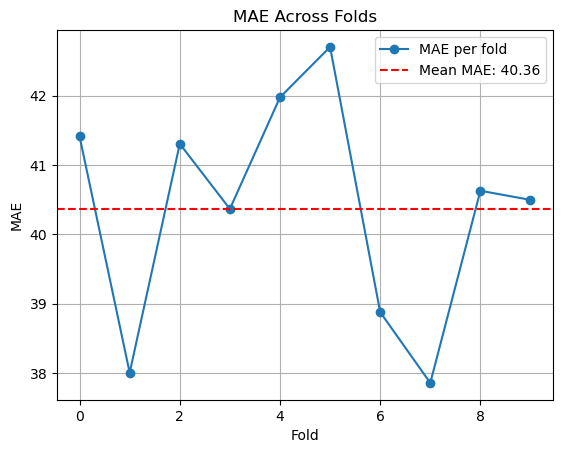

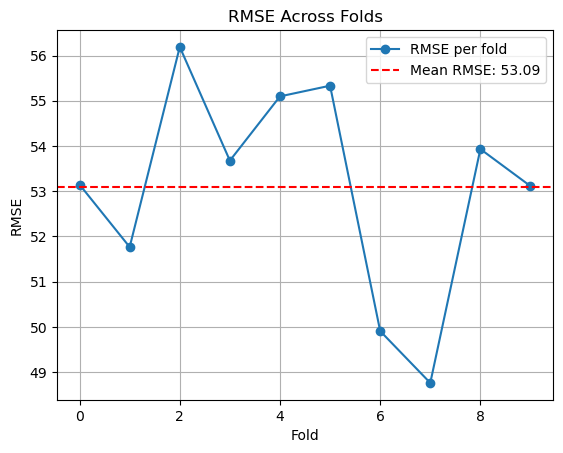

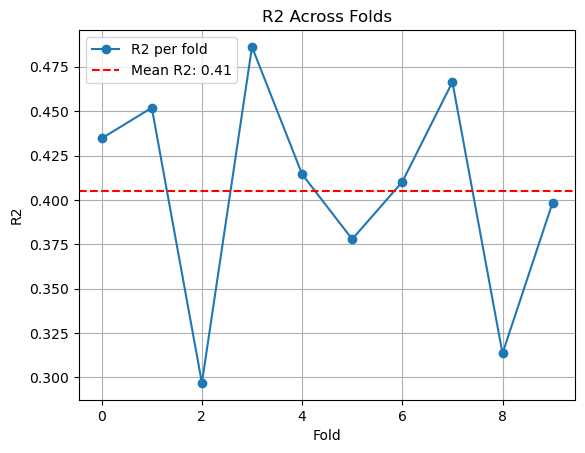

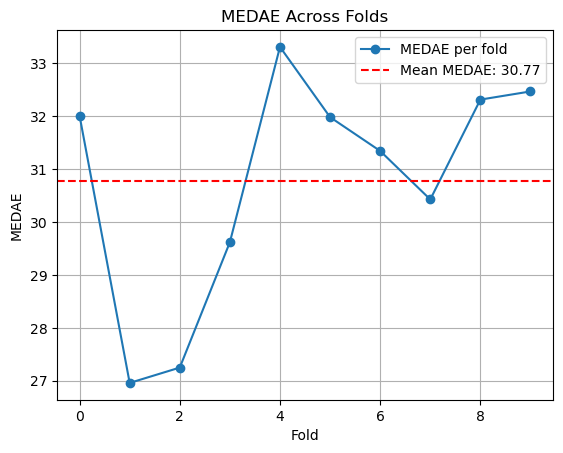

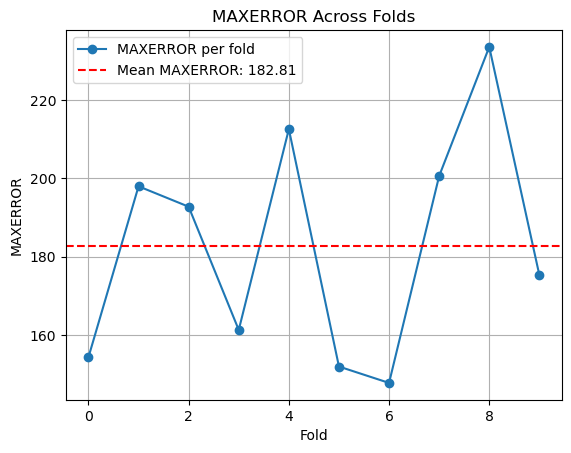

In [73]:
plot_cv_scores(s)

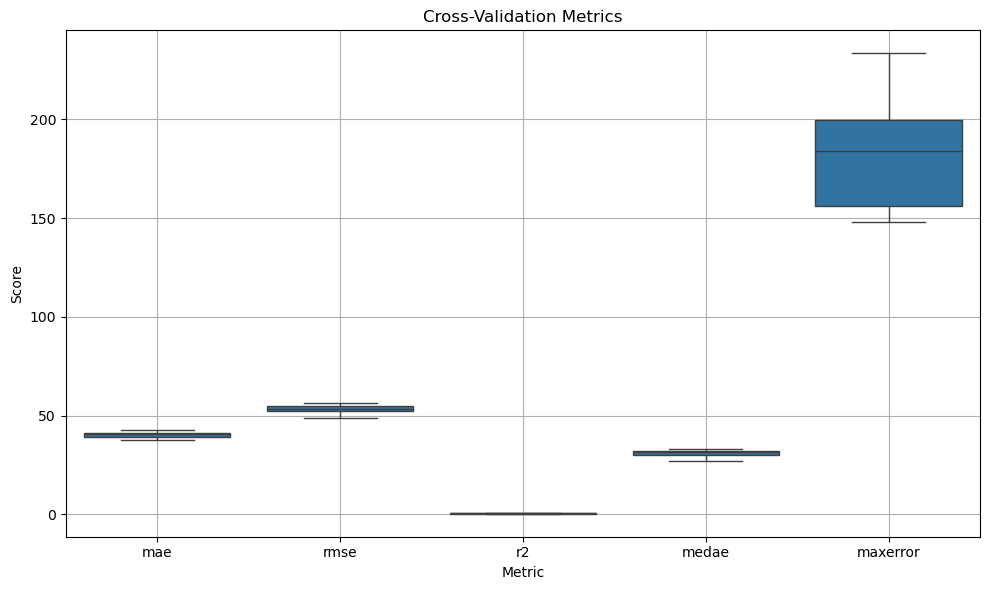

In [76]:
plot_cv_boxplot(s)